In [19]:
import numpy as np
import pandas as pd
import math
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import copy

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import ADASYN
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# Load the data
# This assumes data is in a DataFrame called df with 'NDVI', 'NBR', 'NDWI' and 'NDBI'
# as columns and 'label' as target column
data = pd.read_csv('../dataset_tables/final_dataset.csv')

def convert_string_to_list(item):
    if isinstance(item, (int, float)):
        return [item]
    s = str(item)
    s = s.replace('nan', '0')
    lst = ast.literal_eval(s)
    return lst

In [3]:
data['NDVI'] = data['NDVI'].apply(lambda x: convert_string_to_list(x))
data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))
data['NDWI'] = data['NDWI'].apply(lambda x: convert_string_to_list(x))
data['NDBI'] = data['NDBI'].apply(lambda x: convert_string_to_list(x))

# X = np.array([np.ravel(nbr + ndvi + ndwi + ndbi)
#         for nbr, ndvi, ndwi, ndbi
#         in zip(data['NBR'], data['NDVI'], data['NDWI'], data['NDBI'])])

X = np.array([np.ravel(ndvi + ndwi + ndbi)
        for ndvi, ndwi, ndbi
        in zip(data['NDVI'], data['NDWI'], data['NDBI'])])

y = data['Label'].values

In [4]:
# 初始化ADASYN对象
adasyn = ADASYN(random_state=42)

# 应用ADASYN过采样
X_res, y_res = adasyn.fit_resample(X, y)

In [5]:
# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [6]:
# Data resampling based on weights for the training set
class_counts = np.bincount(y_train.astype(int))
weights = 1. / class_counts
samples_weights = weights[y_train.astype(int)]
samples_weights_tensor = torch.from_numpy(samples_weights).double()
sampler = WeightedRandomSampler(samples_weights_tensor, len(samples_weights_tensor))

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


In [7]:
# Dataset class
class MyDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        # Assuming each feature set is a combination of three images each as single channel
        num_total_features = self.X_data.shape[1]
        num_features_per_image = num_total_features // 3
        height = width = int(math.sqrt(num_features_per_image))
        image = self.X_data[index].reshape(3, height, width)
        label = self.y_data[index]
        return image, label

# Create DataLoaders
train_dataset = MyDataset(X_train_tensor, y_train_tensor)
val_dataset = MyDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=10, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=10)

In [8]:
# Load and modify a pre-trained ResNet model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # Adapted for binary classification

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/Users/glenn_hyh/Documents/github/bc-wildfire-prediction/neu-capstone-venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/glenn_hyh/Documents/github/bc-wildfire-prediction/neu-capstone-venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Train the model with early stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
epochs = 50
best_val_loss = float('inf')
best_model = None
patience = 10
patience_counter = 0

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping!")
            break

# Load the best model for further use or evaluation
model = best_model

Epoch 1, Validation Loss: 2.2682
Epoch 2, Validation Loss: 0.6672
Epoch 3, Validation Loss: 1.0218
Epoch 4, Validation Loss: 0.9182
Epoch 5, Validation Loss: 1.4653
Epoch 6, Validation Loss: 1.1760
Epoch 7, Validation Loss: 1.5773
Epoch 8, Validation Loss: 1.3409
Epoch 9, Validation Loss: 1.3877
Epoch 10, Validation Loss: 0.5951
Epoch 11, Validation Loss: 0.5827
Epoch 12, Validation Loss: 1.7920
Epoch 13, Validation Loss: 0.4043
Epoch 14, Validation Loss: 0.8659
Epoch 15, Validation Loss: 0.3256
Epoch 16, Validation Loss: 0.5050
Epoch 17, Validation Loss: 0.5101
Epoch 18, Validation Loss: 1.4225
Epoch 19, Validation Loss: 0.4010
Epoch 20, Validation Loss: 0.4263
Epoch 21, Validation Loss: 0.5423
Epoch 22, Validation Loss: 0.4593
Epoch 23, Validation Loss: 0.5610
Epoch 24, Validation Loss: 0.7868
Epoch 25, Validation Loss: 0.4847
Early stopping!


In [10]:
# Convert test data to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create test dataset and loader
test_dataset = MyDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=10)

# Predict the labels for test dataset
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

In [11]:
# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.66      0.71        41
           1       0.72      0.82      0.77        44

    accuracy                           0.74        85
   macro avg       0.75      0.74      0.74        85
weighted avg       0.74      0.74      0.74        85



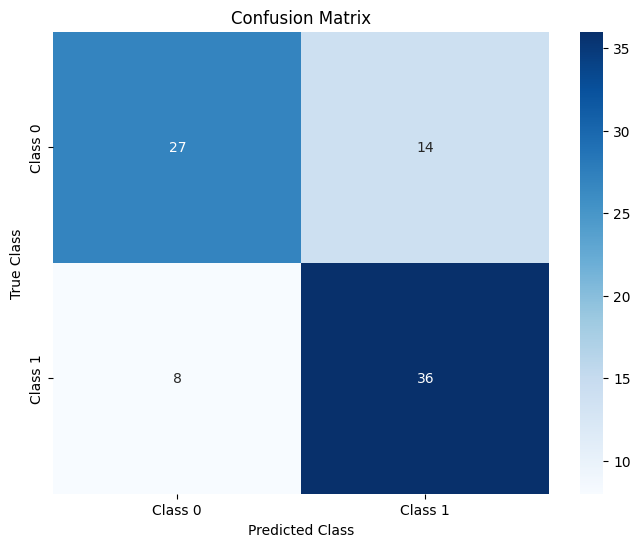

In [12]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [18]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.7412
Precision: 0.7200
Recall: 0.8182
F1 Score: 0.7660


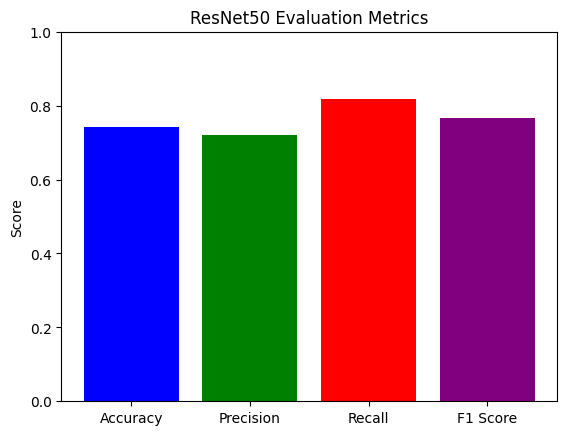

In [17]:
# Visualize the model evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Score')
plt.title('ResNet50 Evaluation Metrics')
plt.ylim(0, 1)  # to set y-axis limits from 0 to 1
plt.show()

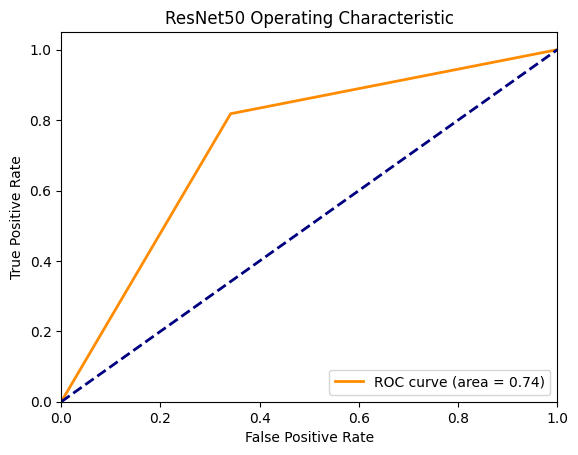

In [21]:
# ROC-AUC curve and score
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 Operating Characteristic')
plt.legend(loc="lower right")
plt.show()